In [1]:
!pip3 freeze > requirements.txt

In [1]:

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# import ipywidgets as widgets
import torch
import torch.optim as optim
from tqdm import tqdm
from sklearn.datasets import make_moons
import seaborn as sns

sns.set_style("white")
cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
cmap_uncertainty = sns.cubehelix_palette(light=1, as_cmap=True)

# from tueplots import bundles
# bundles.icml2022() 
# plt.rcParams.update(bundles.icml2022())

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib
from math import sqrt
SPINE_COLOR = 'gray'


def latexify(fig_width=None, fig_height=None, columns=1):
    """Set up matplotlib's RC params for LaTeX plotting.
    Call this before plotting a figure.

    Parameters
    ----------
    fig_width : float, optional, inches
    fig_height : float,  optional, inches
    columns : {1, 2}
    """

    # code adapted from http://www.scipy.org/Cookbook/Matplotlib/LaTeX_Examples

    # Width and max height in inches for IEEE journals taken from
    # computer.org/cms/Computer.org/Journal%20templates/transactions_art_guide.pdf

    assert(columns in [1,2])

    if fig_width is None:
        fig_width = 3.39 if columns==1 else 6.9 # width in inches

    if fig_height is None:
        golden_mean = (sqrt(5)-1.0)/2.0    # Aesthetic ratio
        fig_height = fig_width*golden_mean # height in inches

    MAX_HEIGHT_INCHES = 8.0
    if fig_height > MAX_HEIGHT_INCHES:
        print("WARNING: fig_height too large:" + fig_height + 
              "so will reduce to" + MAX_HEIGHT_INCHES + "inches.")
        fig_height = MAX_HEIGHT_INCHES

    params = {'backend': 'ps',
              'text.latex.preamble': r'\usepackage{gensymb}',
              'axes.labelsize': 8, # fontsize for x and y labels (was 10)
              'axes.titlesize': 8,
              'font.size': 8, # was 10
              'legend.fontsize': 8, # was 10
              'xtick.labelsize': 8,
              'ytick.labelsize': 8,
              'text.usetex': True,
              'figure.figsize': [fig_width,fig_height],
              'font.family': 'serif'
    }

    matplotlib.rcParams.update(params)


def format_axes(ax):

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for spine in ['left', 'bottom']:
        ax.spines[spine].set_color(SPINE_COLOR)
        ax.spines[spine].set_linewidth(0.5)

    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')

    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_tick_params(direction='out', color=SPINE_COLOR)

    return ax

In [3]:
latexify()

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

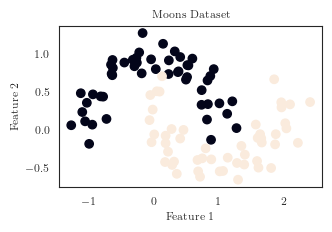

In [5]:

def make_moon_dataset(num_sample = 100, noise = 0.15):
    # Generate the moons dataset
    X, y = make_moons(n_samples=num_sample, noise=noise, random_state=42)

    # Plot the dataset
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title("Moons Dataset")
    plt.show()

make_moon_dataset()
# widgets.interact(make_moon_dataset, num_sample = (100, 1000, 50), noise = (0.05, 1, 0.05))

# Rotating the plot

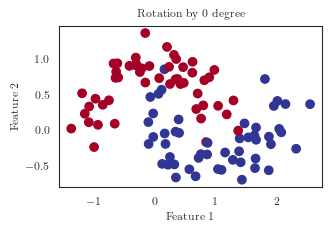

In [7]:

# Function to rotate a dataset by a specified angle
def rotate_dataset(X, angle_degrees):
    # Convert angle from degrees to radians
    angle_radians = np.radians(angle_degrees)
    
    # Create a rotation matrix
    rotation_matrix = np.array([[np.cos(angle_radians), -np.sin(angle_radians)],
                                 [np.sin(angle_radians), np.cos(angle_radians)]])
    
    # Apply the rotation to the dataset
    rotated_X = X.dot(rotation_matrix)
    
    return rotated_X

# List of angles in degrees by which to rotate the dataset

def plot_rotated_moon_dataset(num_samples = 100, noise = 0.2, rotated_angle = 0):
    X, y = make_moons(n_samples = num_samples, noise=noise, random_state=42)
    rotated_X = rotate_dataset(X, rotated_angle)
    plt.scatter(rotated_X[:, 0], rotated_X[:, 1], c = y, cmap=plt.cm.RdYlBu)
    plt.xlabel("Feature 1")
    plt.ylabel("Feature 2")
    plt.title(f"Rotation by {rotated_angle} degree")
    plt.show()

plot_rotated_moon_dataset()
# widgets.interact(plot_rotated_moon_dataset, num_samples = (100, 1000, 100), noise = (0, 1, 0.05), rotated_angle = (0, 360, 5))

# Model Initialization  

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class Encoder(nn.Module):
    def __init__(self, layout, activation = torch.relu):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = self.layers[-1](x)
        return x

class Decoder(nn.Module):
    def __init__(self, layout, activation):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList()
        self.activation = activation
        for i in range(len(layout)):
            self.layers.append(nn.Linear(layout[i][0], layout[i][1]))

        
    def forward(self, x):
        for layer in self.layers[: -1]:
            x = self.activation(layer(x))
        x = F.sigmoid(self.layers[-1](x))
        return x

class Aggregator(nn.Module):
    def __init__(self):
        super(Aggregator, self).__init__()
        
    def forward(self, x):
        return torch.mean(x, dim=0)

class CNP(nn.Module):
    def __init__(self, layout_encoder, layout_decoder, activation):
        super(CNP, self).__init__()
        self.encoder = Encoder(layout_encoder, activation)
        self.decoder = Decoder(layout_decoder, activation)
        self.aggregator = Aggregator()
        
    def forward(self, contextx, contexty, targetx):
        context = torch.cat([contextx, contexty], dim=1)
        encoded_context = self.encoder(context)
        aggregated = self.aggregator(encoded_context)
        decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, contextx.shape[1])], dim=1)
        output = self.decoder(decoder_input)
        return output


# class Encoder(nn.Module):
#     def __init__(self):
#         super(Encoder, self).__init__()
#         self.fc1 = nn.Linear(3, 256)
#         self.fc2 = nn.Linear(256, 256)
#         self.fc3 = nn.Linear(256, 256)
#         self.fc6 = nn.Linear(256, 128)

        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc6(x)
#         return x

# class Decoder(nn.Module):
#     def __init__(self):
#         super(Decoder, self).__init__()
#         self.fc1 = nn.Linear(130, 256)
#         self.fc2 = nn.Linear(256, 256)
#         self.fc5 = nn.Linear(256, 256)
#         self.fc6 = nn.Linear(256, 1)
        
#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x= F.relu(self.fc5(x))
#         x = F.sigmoid(self.fc6(x))
#         return x

# class Aggregator(nn.Module):
#     def __init__(self):
#         super(Aggregator, self).__init__()
        
#     def forward(self, x):
#         return torch.mean(x, dim=0)

# class cnp(nn.Module):
#     def __init__(self):
#         super(cnp, self).__init__()
#         self.encoder = Encoder()
#         self.decoder = Decoder()
#         self.aggregator = Aggregator()
        
#     def forward(self, contextx, contexty, targetx):
#         context = torch.cat([contextx, contexty.unsqueeze(1)], dim=1)
#         encoded_context = self.encoder(context)
#         aggregated = self.aggregator(encoded_context)
#         decoder_input = torch.cat([aggregated.unsqueeze(0).expand(len(targetx),-1), targetx.view(-1, 2)], dim=1)
#         output = self.decoder(decoder_input)
#         return output
    



# Training The Make moons Dataset

In [9]:
# make random 100 angles between 0 and 360

def take_random_angles(size = 100):
    return np.random.randint(0, 361, size)
    # angles = [i for i in range(0, 360, 3)]
    # return np.random.choice(angles, size)
# angles=[i for i in range(0,360,3)]
# 
# print(len(angles))

# select 100 random angles from the list of 120 angles

# angles=np.random.choice(angles,100)


def generate_make_moons(num_samples, angle, noise = 0.15):
    X, y = make_moons(n_samples=num_samples, noise=noise, random_state=42)
    X = rotate_dataset(X, angle)
    return X, y

def train_make_moons(num_epochs = 1000, num_samples = 150, noise = 0.15, angles_count = 100, context_size = 50, target_size = 100):
    # model and loss initialization
    
    encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # angles_count = 100
    angles = take_random_angles(angles_count)

    # num_samples = 150
    training_data =[generate_make_moons(num_samples = num_samples, angle = angles[i], noise = noise) for i in range(angles_count)]

    
    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 99) # possible values of index to look for 
        # print(context)


        target_x=training_data[train_set][0][target]
        target_y=training_data[train_set][1][target]
        context_x=training_data[train_set][0][context]
        context_y=training_data[train_set][1][context]


        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x, context_y, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        losses.append(loss.item())
    
    plt.plot(np.arange(num_epochs), np.log(losses))
    plt.xlabel('Epochs')
    plt.ylabel("Loss (Log)")
    plt.title("Loss vs Epoch")
    plt.show()
    print(f"losses {losses}")
    return model






100%|██████████| 10000/10000 [00:18<00:00, 535.52it/s]


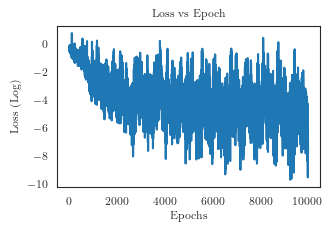

losses [0.6926158666610718, 0.6998023986816406, 0.6951005458831787, 0.690380871295929, 0.6843324303627014, 0.676099956035614, 0.670693039894104, 0.6980363726615906, 0.7098375558853149, 0.6631993651390076, 0.6539864540100098, 0.6610181927680969, 0.6615282297134399, 0.6179830431938171, 0.6989755034446716, 0.8069209456443787, 0.5983418822288513, 0.6016415953636169, 0.696546733379364, 0.6691489219665527, 0.5955349802970886, 0.6399521827697754, 0.5800797939300537, 0.5994314551353455, 0.7995266914367676, 0.9272494316101074, 0.5875788331031799, 0.7570618391036987, 0.5183295011520386, 0.5479304790496826, 0.7719249129295349, 0.905855119228363, 0.8515936136245728, 0.8593699932098389, 0.669365406036377, 0.6663510799407959, 0.6602222323417664, 0.7434353828430176, 0.7173680067062378, 0.7006497383117676, 0.6653047204017639, 0.6735578775405884, 0.6610347032546997, 0.6632131338119507, 0.6505954265594482, 0.7398765683174133, 0.654223620891571, 0.6525475978851318, 0.6554824113845825, 0.6452199816703796,

In [10]:
model = train_make_moons(10000, num_samples=150, noise= 0.15, angles_count=100, context_size= 50, target_size=100)


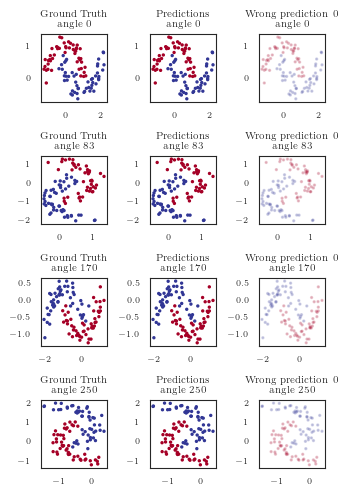

In [18]:

def testing(model, num_samples = 150, noise = 0.15,  context_x_size = 10, target_size = 100, angles = [0, 83, 170, 250]):
    # angle=np.random.randint(0,360)
    # print(angle)

    fig, ax = plt.subplots(4, 3, figsize = (3.39, 5))
    for i, angle in enumerate(angles):

        test_data=generate_make_moons(num_samples, angle, noise= noise)
        
        x_range = np.linspace(-2, 2, 100)
        y_range = np.linspace(-2, 2, 100)
        xx, yy = np.meshgrid(x_range, y_range)

        context=np.random.choice(num_samples, context_x_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)


        target_x=test_data[0][target]
        target_y=test_data[1][target]
        context_x=test_data[0][context]
        context_y=test_data[1][context]

        # print(context_y)

        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        predictions = model(context_x, context_y, target_x)
        predictions=(predictions>0.5).float()


        wrong_predictions = predictions.detach().numpy().reshape(-1, 1) != target_y.numpy()
        wrong_predictions = wrong_predictions.reshape(-1)

        # ax = axes[i]
        ax[i][0].scatter(target_x[:, 0], target_x[:, 1], c=target_y, cmap=plt.cm.RdYlBu, s = 2)
        ax[i][0].set_title(f"Ground Truth\nangle {angle}", fontsize =7)
        ax[i][1].scatter(target_x[:, 0], target_x[:, 1], c=predictions.detach().numpy(), cmap=plt.cm.RdYlBu, s = 2 )
        ax[i][1].set_title(f"Predictions\nangle {angle}", fontsize = 7)
        ax[i][2].scatter(target_x[wrong_predictions, 0], target_x[wrong_predictions, 1], c=target_y[wrong_predictions].unsqueeze(0), cmap=plt.cm.RdYlBu, s = 2)
        ax[i][2].scatter(target_x[:, 0], target_x[:, 1], c=target_y, cmap=plt.cm.RdYlBu, alpha=0.2, s = 2)
        ax[i][2].set_title(f"Wrong prediction {sum(wrong_predictions)} \n angle {angle}", fontsize = 7)
        ax[i][0].tick_params(axis='both', which='both', labelsize=6)
        ax[i][1].tick_params(axis='both', which='both', labelsize=6)
        ax[i][2].tick_params(axis='both', which='both', labelsize=6)
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.25, hspace=0.45)
    plt.savefig("plots/make_moon_4_different_angles.pdf", format = 'pdf', bbox_inches = "tight")
    plt.show()


testing(model)
# widgets.interact(testing, model = widgets.fixed(model) , num_samples = (50, 1000, 50), noise = (0, 2, 0.05), context_x_size = (1, 1000, 2), target_size = (100, 1000, 10), angle = (0, 360, 0.5))

# Training till 180 angles and predicting angles > 180

100%|██████████| 10000/10000 [00:19<00:00, 514.81it/s]


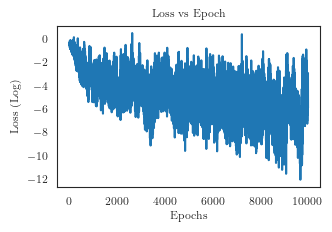

In [19]:
# make random 100 angles between 0 and 360

def take_random_angles(size = 100):
    return np.random.randint(0, 180, size)
    # angles = [i for i in range(0, 360, 3)]
    # return np.random.choice(angles, size)
# angles=[i for i in range(0,360,3)]
# 
# print(len(angles))

# select 100 random angles from the list of 120 angles

# angles=np.random.choice(angles,100)


def generate_make_moons(num_samples, angle, noise = 0.15):
    X, y = make_moons(n_samples=num_samples, noise=noise, random_state=42)
    X = rotate_dataset(X, angle)
    return X, y

def train_make_moons(num_epochs = 1000, num_samples = 150, noise = 0.15, angles_count = 100, context_size = 50, target_size = 100):
    # model and loss initialization
    
    encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # angles_count = 100
    angles = take_random_angles(angles_count)

    # num_samples = 150
    training_data =[generate_make_moons(num_samples = num_samples, angle = angles[i], noise = noise) for i in range(angles_count)]

    
    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 99) # possible values of index to look for 


        target_x=training_data[train_set][0][target]
        target_y=training_data[train_set][1][target]
        context_x=training_data[train_set][0][context]
        context_y=training_data[train_set][1][context]


        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x, context_y, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        losses.append(loss.item())
    
    plt.plot(np.arange(num_epochs), np.log(losses))
    plt.xlabel('Epochs')
    plt.ylabel("Loss (Log)")
    plt.title("Loss vs Epoch")
    plt.show()
    return model





model2 = train_make_moons(10000, num_samples=150, noise= 0.15, angles_count=100, context_size= 50, target_size=100)

    

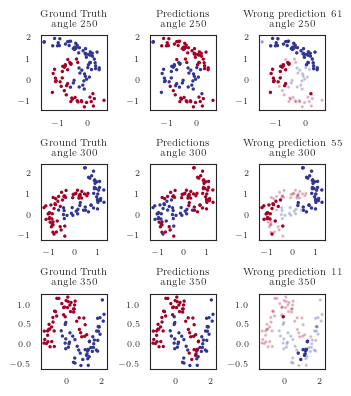

In [21]:

def testing(model, num_samples = 150, noise = 0.15,  context_x_size = 10, target_size = 100, angles = [ 250, 300, 350]):
    # angle=np.random.randint(0,360)
    # print(angle)

    fig, ax = plt.subplots(3, 3, figsize=(3.3, 4))
    for i, angle in enumerate(angles):

        test_data=generate_make_moons(num_samples, angle, noise= noise)
        
        x_range = np.linspace(-2, 2, 100)
        y_range = np.linspace(-2, 2, 100)
        xx, yy = np.meshgrid(x_range, y_range)

        context=np.random.choice(num_samples, context_x_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)


        target_x=test_data[0][target]
        target_y=test_data[1][target]
        context_x=test_data[0][context]
        context_y=test_data[1][context]

        # print(context_y)

        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        predictions = model(context_x, context_y, target_x)
        predictions=(predictions>0.5).float()


        wrong_predictions = predictions.detach().numpy().reshape(-1, 1) != target_y.numpy()
        wrong_predictions = wrong_predictions.reshape(-1)

        # ax = axes[i]
        ax[i][0].scatter(target_x[:, 0], target_x[:, 1], c=target_y, cmap=plt.cm.RdYlBu, s = 2)
        ax[i][0].set_title(f"Ground Truth\nangle {angle}", fontsize = 7)
        ax[i][1].scatter(target_x[:, 0], target_x[:, 1], c=predictions.detach().numpy(), cmap=plt.cm.RdYlBu, s = 2)
        ax[i][1].set_title(f"Predictions\nangle {angle}", fontsize = 7)
        ax[i][2].scatter(target_x[wrong_predictions, 0], target_x[wrong_predictions, 1], c=target_y[wrong_predictions].unsqueeze(0), cmap=plt.cm.RdYlBu, s = 2)
        ax[i][2].scatter(target_x[:, 0], target_x[:, 1], c=target_y, cmap=plt.cm.RdYlBu, alpha=0.2, s = 2)
        ax[i][2].set_title(f"Wrong prediction {sum(wrong_predictions)}\nangle {angle}", fontsize = 7)
        ax[i][0].tick_params(axis='both', which='both', labelsize=6)
        ax[i][1].tick_params(axis='both', which='both', labelsize=6)
        ax[i][2].tick_params(axis='both', which='both', labelsize=6)

    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.25, hspace=0.45)
    plt.savefig("plots/extrapolation_make_moons.pdf", format = 'pdf', bbox_inches = "tight")
    plt.show()


testing(model2)
# widgets.interact(testing, model = widgets.fixed(model) , num_samples = (50, 1000, 50), noise = (0, 2, 0.05), context_x_size = (1, 1000, 2), target_size = (100, 1000, 10), angle = (0, 360, 0.5))

# Change of surface with different contexts

100%|██████████| 10000/10000 [00:18<00:00, 530.80it/s]


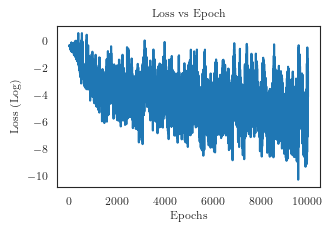

In [22]:
# make random 100 angles between 0 and 360

def take_random_angles(size = 100):
    return np.random.randint(0, 360, size)
    # angles = [i for i in range(0, 360, 3)]
    # return np.random.choice(angles, size)
# angles=[i for i in range(0,360,3)]
# 
# print(len(angles))

# select 100 random angles from the list of 120 angles

# angles=np.random.choice(angles,100)


def generate_make_moons(num_samples, angle, noise = 0.15):
    X, y = make_moons(n_samples=num_samples, noise=noise, random_state=42)
    X = rotate_dataset(X, angle)
    return X, y

def train_make_moons(num_epochs = 1000, num_samples = 150, noise = 0.15, angles_count = 100, context_size = 50, target_size = 100):
    # model and loss initialization
    
    encoder_layout = [[3, 256], [256, 256], [256, 256], [256, 128]]
    decoder_layout = [[130, 256], [256, 256], [256, 256], [256, 1]]

    model = CNP(encoder_layout, decoder_layout, F.relu)
    
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # angles_count = 100
    angles = take_random_angles(angles_count)

    # num_samples = 150
    training_data =[generate_make_moons(num_samples = num_samples, angle = angles[i], noise = noise) for i in range(angles_count)]

    
    losses = []
    for epoch in tqdm(range(num_epochs)):
        
        context=np.random.choice(num_samples, context_size, replace=False)
        target=np.random.choice(num_samples, target_size, replace=False)
        train_set=np.random.randint(0, 99) # possible values of index to look for 


        target_x=training_data[train_set][0][target]
        target_y=training_data[train_set][1][target]
        context_x=training_data[train_set][0][context]
        context_y=training_data[train_set][1][context]


        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        target_y = torch.tensor(target_y, dtype=torch.float32).view(-1, 1)

        # print(f"contextx shape: {context_x.shape} context y shape {context_y.shape} target x shape {target_x.shape} target y {target_y.shape}")
        
        model.train()
        optimizer.zero_grad()
        predictions = model(context_x, context_y, target_x)
        loss = criterion(predictions, target_y.view(-1, 1))
        loss.backward()
        optimizer.step()
        # print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")
        losses.append(loss.item())
    
    plt.plot(np.arange(num_epochs), np.log(losses))
    plt.xlabel('Epochs')
    plt.ylabel("Loss (Log)")
    plt.title("Loss vs Epoch")
    plt.show()
    return model





model3 = train_make_moons(10000, num_samples=150, noise= 0.15, angles_count=100, context_size= 50, target_size=100)

    


82.66666666666667
97.33333333333334
92.0
96.0
94.66666666666667
95.33333333333334


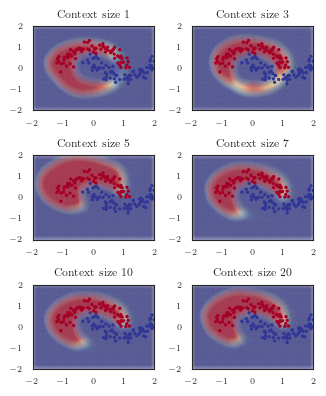

In [60]:
from sklearn.metrics import accuracy_score

def testing(model, num_samples = 150, noise = 0.15,  context_x_sizes = [1, 3, 5, 7, 10, 20], target_size = 100, angle = 0):
    # angle=np.random.randint(0,360)
    # print(angle)
    test_data = generate_make_moons(num_samples, angle, noise= noise)

    fig, axes = plt.subplots(3, 2, figsize=(3.3, 4))
    axes = axes.flatten()
    acc_lst = []
    for i, context_x_size in enumerate(context_x_sizes):
        x_range = np.linspace(-2, 2, 100)
        y_range = np.linspace(-2, 2, 100)
        xx, yy = np.meshgrid(x_range, y_range)
        target_x= np.column_stack((yy.reshape(-1), xx.reshape(-1)))

        context=np.random.choice(num_samples, context_x_size, replace=False)
        context_x=test_data[0][context]
        context_y=test_data[1][context]

        context_x = torch.tensor(context_x, dtype=torch.float32)
        context_y = torch.tensor(context_y, dtype=torch.float32).view(-1, 1)
        target_x = torch.tensor(target_x, dtype=torch.float32)
        test_x = torch.tensor(test_data[0], dtype=torch.float32)
        test_y = torch.tensor(test_data[1], dtype=torch.int16)


        predictions = model(context_x, context_y, test_x)
        predictions=(predictions>0.5).int().numpy()
        test_y = test_y.detach().numpy()
        acc = accuracy_score(test_y, predictions) * 100
        # print(predictions.view(num_samples).shape,  test_y.shape)
        # acc = np.mean(predictions.reshape(num_samples) == test_y)*100
        print(acc)
        acc_lst.append(acc)
        # print(f"predciton shape {predictions.shape}test_y {test_y.shape}")
        
        # mse_lst.append(error.item()/(i+1))

        predictions_grid = model(context_x, context_y, target_x)

        
        # # print(context_y)
        test_data_x = test_data[0]
        test_data_y = test_data[1]
        ax = axes[i]
        target_x = target_x.detach().numpy()
        predictions_grid = predictions_grid.detach().numpy()
        # print(f"target x shape {target_x.shape} {predictions.shape}")
        # contour = ax.contourf(
        #     target_x[:, 1].reshape((100, 100)),
        #     target_x[:, 0].reshape((100, 100)),
        #     predictions_grid.reshape(100, 100),
        #     cmap=cmap,
        #     alpha = 0.8
        # )
        ax.scatter(target_x[:, 0], target_x[:, 1], c = predictions_grid.flatten(), cmap= plt.cm.RdYlBu, alpha=0.01)
        ax.scatter(test_data_x[:, 0], test_data_x[:, 1], c = test_data_y, cmap = plt.cm.RdYlBu, s = 2)
        ax.set_xlim(-2, 2)
        ax.set_ylim(-2, 2)
        ax.set_title(f"Context size {context_x_size}", fontsize = 8)
        ax.tick_params(axis='both', which='both', labelsize=6)
        # ax.colorbar()
    
    plt.tight_layout()
    # plt.subplots_adjust(wspace=0.25, hspace=0.45)
    plt.savefig("plots/make_moon_surface_with_context.pdf", format = 'pdf', bbox_inches="tight")
    plt.show()
    return acc_lst

mse_lst =  testing(model3)


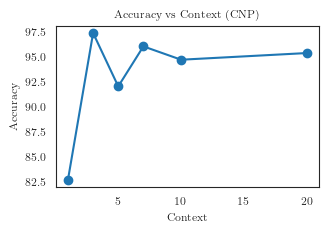

In [61]:
c = [1, 3, 5, 7, 10, 20]
fig, ax = plt.subplots()  # Width = 3*5 inches, Height = 5 inches
plt.plot(c, mse_lst, marker='o', linestyle='-')
plt.title(f'Accuracy vs Context (CNP)')
plt.xlabel('Context')
plt.ylabel('Accuracy')
# plt.ylim(80, 100)
ax.tick_params(axis='both', which='both')
plt.savefig("plots/performance_make_moon_context.pdf", format="pdf", bbox_inches="tight")
plt.show()